In [1]:
library(ggplot2)
library(dplyr)
library(stringr)
library(forecast)
library(LaplacesDemon)
library(reshape)
library(gsynth)
library(readxl)
library(reshape)
library(lubridate)
library(zoo)
library(MASS)
library(doParallel)
library(foreach)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘LaplacesDemon’


The following object is masked from ‘package:forecast’:

    is.constant



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘lubridate’


The following object is masked from ‘package:reshape’:

    stamp


The following objects are masked from ‘package:LaplacesDemon’:

    dst, interval


The following objects are masked from ‘package:dplyr’:

    intersect, setdiff, union


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘zoo’


The followin

In [2]:
variableExpander <- function(keysAndVariable, unitKey, timeKey){ ### Expands into unit/time format
  
  orderedData <- keysAndVariable %>% arrange(get(unitKey), get(timeKey))
  
  outcomeName <- names(keysAndVariable)[!(names(keysAndVariable) %in% c(unitKey, timeKey))]
  
  outcomeMatrixForm <- matrix(NA, nrow=length(unique(keysAndVariable[, unitKey])), 
                              ncol=length(unique(keysAndVariable[, timeKey])), byrow=T)
  
  rownames(outcomeMatrixForm) <- unique(keysAndVariable[, unitKey])
  
  colnames(outcomeMatrixForm) <- str_replace_all(unique(keysAndVariable[, timeKey])[order(unique(keysAndVariable[, timeKey]))], pattern="-", replace="")
  
  for (index in 1:length(keysAndVariable[, unitKey])){
    
    outcomeMatrixForm[keysAndVariable[, unitKey][index], str_replace_all(keysAndVariable[, timeKey][index], pattern="-", replace="")] <- keysAndVariable[, outcomeName][index]
    
  }
  
  return(outcomeMatrixForm)
  
}

In [3]:
source('../../causal_inference_methods_code_corrupted.R')

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:reshape’:

    expand


Loaded glmnet 3.0-2




In [4]:
list.files()

[1] "Assess Effect of Michael Leaving.ipynb"   
[2] "big tv rating data.csv"                   
[3] "IMDb Rating Cleaning.ipynb"               
[4] "Office Ratings (with Michael Leaving).pdf"
[5] "plots_and_tables"                         
[6] "tv rating data.csv"

In [5]:
max_available_clusters <- detectCores()-1
  
desired_clusters <- 4
  
cl <- makeCluster(min(c(max_available_clusters, desired_clusters)))

registerDoParallel(cl)

In [6]:
officeCode <- 'tt0386676'

In [7]:
tvData = read.csv("big tv rating data.csv")

orderedTvData <- tvData %>% arrange(Title, Episode.Number)

orderedTvData <- orderedTvData %>% mutate(
    condensedNumber=rep(1:50, length(unique(tvData$Code))))

In [8]:
Y <- variableExpander(orderedTvData[, c('Title', 'condensedNumber', 'Rating')],
                unitKey='Title', timeKey='condensedNumber')


D <- variableExpander(orderedTvData[, c('Title', 'condensedNumber', 'main_character_left')],
                unitKey='Title', timeKey='condensedNumber')

In [9]:
#chosenSeries <- orderedTvData %>% filter(Title %in% c("Avatar: The Last Airbender", "The Legend of Korra",
#    "The X Files", "Samurai Jack", "Community", "The Office"))

chosenSeries <- orderedTvData %>% filter(Title %in% c("The Office", "Community", 
                                                      "Parks and Recreation", "Superstore",
                                                     "The Mindy Project",
                                                     "Psych"))

panelDataExample <- ggplot(chosenSeries, aes(x=condensedNumber, y=Rating, col=Title)) + geom_line(lwd=1.25)  +
theme_bw(base_size=20) + 
facet_wrap(~Title, scales='free') + xlab("Time") + 
ggtitle("Ratings for Comedies on IMDb") + guides(col=FALSE)

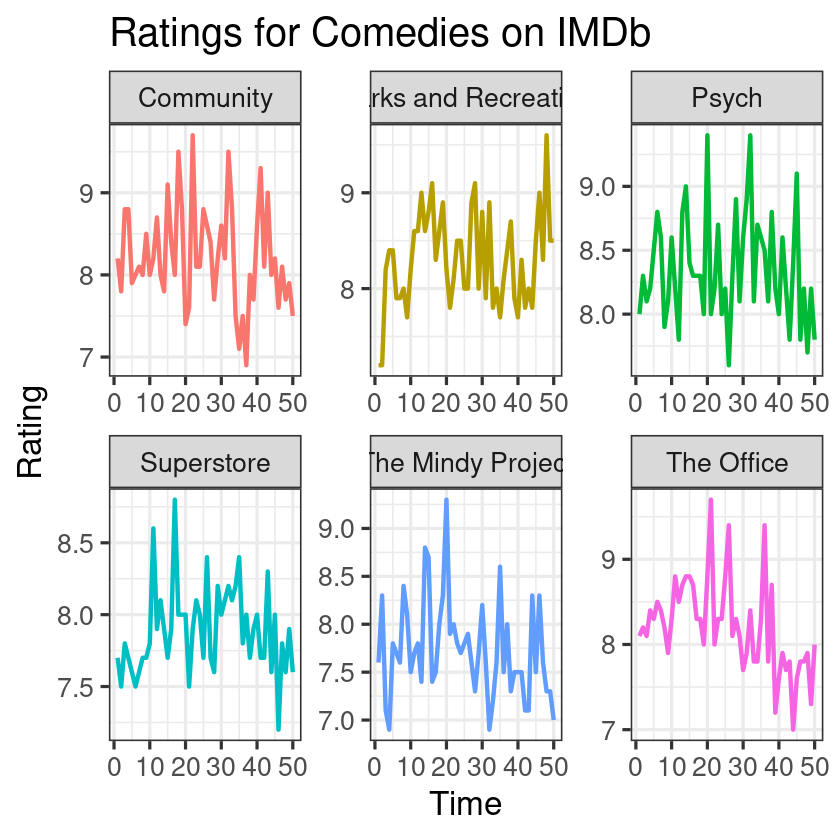

In [10]:
panelDataExample

# Method Performance Assessment

In [52]:
TvCovariate <- orderedTvData %>% group_by(Title) %>% summarize(mean_rating = mean(Rating))

In [53]:
goodPoints <- which(colSums(D)==0)

numberOfPointsToBLockOut <- min(13, max(rowSums(D)))

allNonMissingY <- Y[, goodPoints]

print(paste("Number of shows:", dim(Y)[1]))

[1] "Number of shows: 691"


In [54]:
# dim(allNonMissingY)[1]

numberOfShowsToAssess <- dim(allNonMissingY)[1]


tvRatingErrorMatrix <- array(NA, dim=c(5, 1, numberOfShowsToAssess))

methodNames <- c("MC-NNM", "Weighted softImpute", 
                "FACTOR", 'R1Comp', 'Weighted r1Comp')

dimnames(tvRatingErrorMatrix) <- c(list(methodNames),list('MSE'),
                                   list(dimnames(allNonMissingY)[[1]][1:numberOfShowsToAssess]))

indic <- 1






In [55]:
covariates <- TvCovariate["mean_rating"]

In [56]:
#truehist(as.numeric(as.matrix(covariates)))

In [57]:
scoreBeta <- c(-.25)

In [58]:
Time0 <- 30

simulatedTreatmentData <- parameterMakerBlockProvidedCovariates(
    Time=dim(allNonMissingY)[2],
         modelCovariates=as.matrix(covariates), Time0=Time0, propTreat=.3,
                                     glmBeta=scoreBeta)

In [59]:
observedData <- allNonMissingY * (1-simulatedTreatmentData$W)

In [60]:
treatProfile <- colMeans(observedData[which(rowSums(simulatedTreatmentData$W) > 0),])
untreatProfile <- colMeans(observedData[which(rowSums(simulatedTreatmentData$W) == 0),])

In [83]:
neededTimes <- as.numeric(names(untreatProfile))


averageUnitData <- cbind.data.frame(rep(neededTimes, 2), 
        c(unname(treatProfile), unname(untreatProfile)), rep(c('Treated', 'Untreated'), 
                                                             each=length(neededTimes)))

names(averageUnitData) <- c('Time', 'Average Rating', 'Unit Type')

groupComparisonPlot <- ggplot(averageUnitData %>% filter(Time >= 1 & Time <= 30), 
       aes(x=Time, y=`Average Rating`, col=`Unit Type`)) +
 geom_line(lwd=2) + 
theme_bw(base_size=20) + geom_vline(xintercept = averageUnitData$Time[Time0], lwd=1.5) +
ggtitle("Aggregated TV Ratings")




In [21]:
set.seed(529371)

numSims <- 300

chosenLength <- NULL

#rateOfDecay <- .2
#finalProp <- .6
#Time0 <- 90

Time0 <- 30

for (simNumber in 1:numSims){

    
    
    simulatedTreatmentData <- parameterMakerBlockProvidedCovariates(Time=dim(allNonMissingY)[2],
                                                                modelCovariates=as.matrix(covariates),
                                                                    Time0=Time0, propTreat=.3,
                                     glmBeta=scoreBeta)
            
    if (simNumber ==1){
        
        effects <- array(NA, dim=c(6, dim(allNonMissingY)[2]-Time0, numSims), dimnames=list(c('MC-NNM', 
                                            "Weighted softImpute", 'FACTOR', 'r1Comp', 'Weighted R1Comp', 'Truth'),
                                                                           paste('', 1:(dim(allNonMissingY)[2]-Time0), sep=''),
                                                                           paste('iteration', 1:numSims, sep='_')))
        
        forecastMSES <- array(NA, dim=c(5, numSims), dimnames=list(c('MC-NNM', 
                                            "Weighted softImpute", 'FACTOR', 'r1Comp', 'Weighted R1Comp'),
                                                                           paste('iteration', 1:numSims, sep='_')))
        
    }


    observedData <- allNonMissingY * (1-simulatedTreatmentData$W)
                             
    rownames(observedData) = rownames(observedData)                         
                             
    mc_nnm_info <- matrix_completion_causal(Y=observedData, W=simulatedTreatmentData$W, num_iter=1000, K=4, 
                                            lambda_grid=c(0, 10^seq(-4,2,1), seq(2,5,1)),
                                            tolerance=1e-04)

    weightedSoftImputeInfo <- weightedSoftImpute_validate_lambda(Y=observedData, W=simulatedTreatmentData$W, 
                                        weight_matrix=simulatedTreatmentData$weightMatrixEst, num_iter=1000,
                                        K=5, lambda_grid=seq(0, 2000, 100), tolerance=1e-03)

    L_completionFactorModel <- completion_factor_model(Y=observedData, W=simulatedTreatmentData$W, 
                                                       propScoreMat = simulatedTreatmentData$propScoreEst,
                                                       numFactors=rankMatrix(mc_nnm_info$L_hat)[1])
    
    r1CompInfo <- completion_with_rank_estimation_validate_mu(
                                      Y=observedData, W=simulatedTreatmentData$W  , 
        weight_matrix=array(1, dim=dim(observedData)),
                                      initial_rank=40,
                                      tolerance=1e-04, 
                                      validation_max_iter=5000,
                                      min_iter=100,
                                      max_iter=10000,
                                      mu_grid=0,
                                      K=5)

    weightedR1CompInfo <- completion_with_rank_estimation_validate_mu(
                                      Y=observedData, W=simulatedTreatmentData$W , 
        weight_matrix=simulatedTreatmentData$trueWeightMatrix,
                                      initial_rank=40,
                                      tolerance=1e-04, 
                                      validation_max_iter=5000,
                                      min_iter=100,
                                      max_iter=10000,
                                      mu_grid=0,
                                      K=5)
    
    effects['Weighted R1Comp', , simNumber]  <- treat.estimator(observedData, weightedR1CompInfo$L_hat, simulatedTreatmentData$W)
    
    effects['r1Comp', , simNumber]  <- treat.estimator(observedData, r1CompInfo$L_hat, simulatedTreatmentData$W)
    
    effects['FACTOR', , simNumber] <- treat.estimator(observedData, L_completionFactorModel, simulatedTreatmentData$W)
    
    effects['Weighted softImpute', , simNumber] <-  treat.estimator(observedData, weightedSoftImputeInfo$L_hat, 
                                                                    simulatedTreatmentData$W)

    effects['MC-NNM', , simNumber] <- treat.estimator(observedData, mc_nnm_info$L_hat, simulatedTreatmentData$W) 
    
    effects['Truth', , simNumber] <- treat.estimator(observedData, allNonMissingY, simulatedTreatmentData$W) 
    
    
    
    
                         
    forecastMSES['Weighted R1Comp', simNumber]  <- (norm((weightedR1CompInfo$L_hat-allNonMissingY)*simulatedTreatmentData$W, 'F')/
                                                      sqrt(sum(simulatedTreatmentData$W)))^2
    
    forecastMSES['r1Comp', simNumber]  <- (norm((r1CompInfo$L_hat-allNonMissingY)*simulatedTreatmentData$W, 'F')/
                                                      sqrt(sum(simulatedTreatmentData$W)))^2
    
    forecastMSES['FACTOR', simNumber] <- (norm((L_completionFactorModel-allNonMissingY)*simulatedTreatmentData$W, 'F')/
                                                      sqrt(sum(simulatedTreatmentData$W)))^2
    
   forecastMSES['Weighted softImpute', simNumber] <-(norm((weightedSoftImputeInfo$L_hat-allNonMissingY)*simulatedTreatmentData$W, 'F')/
                                                      sqrt(sum(simulatedTreatmentData$W)))^2

    forecastMSES['MC-NNM', simNumber] <- (norm((mc_nnm_info$L_hat-allNonMissingY)*simulatedTreatmentData$W, 'F')/
                                                      sqrt(sum(simulatedTreatmentData$W)))
    }

In [22]:
forecastMSEData <- cbind.data.frame(rowMeans(forecastMSES), apply(forecastMSES, MARGIN=1, FUN=sd))

names(forecastMSEData) <- c('MSE', 'SE')

forecastMSEDataForLatex <- forecastMSEData %>% mutate(Method = row.names(forecastMSEData), MSE = round(MSE, 3), SE = round(SE, 3),
                                                     `MSE (SE)` = paste(MSE, ' (', SE, ')', sep='')) 

forecastMSEDataForLatex <- forecastMSEDataForLatex[c('Method', 'MSE (SE)')]

forecastMSEDataForLatex <- knitr::kable(forecastMSEDataForLatex, 'latex')

In [46]:
meltedForecastData <- melt(forecastMSES)

names(meltedForecastData) <- c("Method", "Iteration", 'MSE')

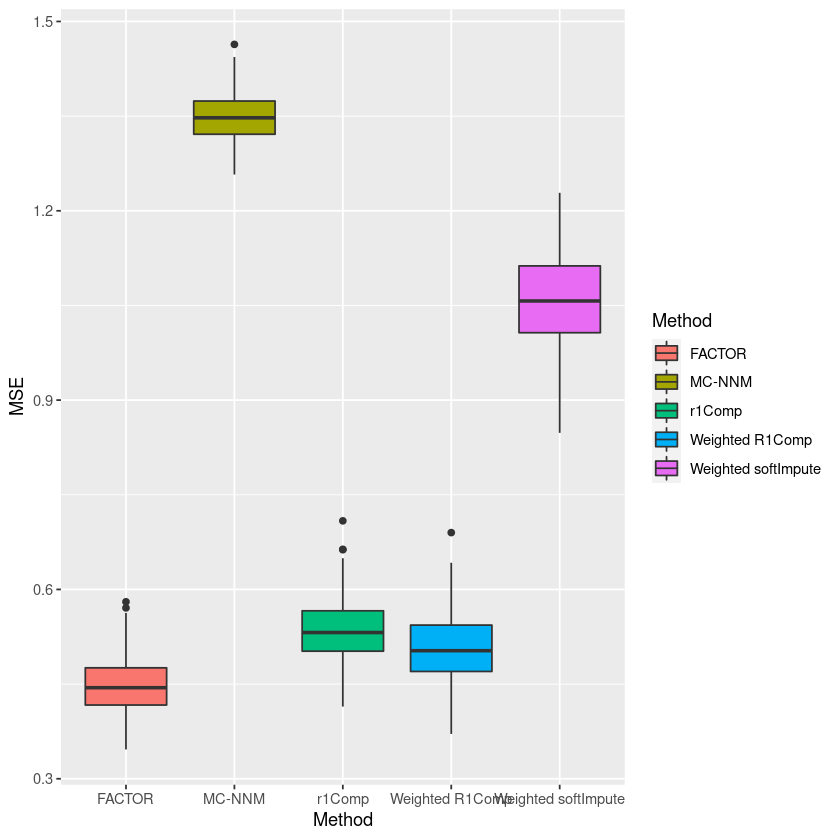

In [50]:
ggplot(meltedForecastData, aes(x=Method, y=MSE, fill=Method)) + geom_boxplot()

In [23]:
meltedEffectData <- melt(effects[,,])

names(meltedEffectData) <- c('Method', 'Time', 'Iteration', 'Effect')
meltedEffectData$Method <- factor(meltedEffectData$Method, 
                                  levels=c("MC-NNM", "Weighted softImpute", 
                                           "FACTOR", 'r1Comp', "Weighted R1Comp", 'Truth'))

In [24]:
#plot(tau_estimate_r1Comp, type='l')

effectDataPaired <- meltedEffectData %>% inner_join(meltedEffectData %>% filter(Method=='Truth') %>% 
                                                    dplyr::select(c("Time", "Iteration", "Effect"))
                                , by=c('Time', 'Iteration') ) %>% filter(Method != 'Truth')

names(effectDataPaired)[4:5] <- c('Effect', 'TrueEffect')

In [25]:
errorTable <- (effectDataPaired %>% group_by(Method) %>% summarize(
    MSE = round(mean((Effect-TrueEffect)^2), 4), SE = round(sd((Effect-TrueEffect)^2)/sqrt(n()), 4))
 %>% arrange(Method))

In [26]:
treatErrorTableForLatex <- errorTable %>% mutate(MSE = round(MSE, 3), SE = round(SE, 3),
                                                     `MSE (SE)` = paste(MSE, ' (', SE, ')', sep='')) 

treatErrorTableForLatex  <- treatErrorTableForLatex[c('Method', 'MSE (SE)')]

treatErrorTableForLatex <- knitr::kable(treatErrorTableForLatex, 'latex')

# Confidence Interval Assessment

In [77]:
set.seed(529371)

numSims <- 2

bootSims <- 30

chosenLength <- NULL

for (simNumber in 1:numSims){
    
    simulatedTreatmentData <- parameterMakerBlockProvidedCovariates(Time=dim(allNonMissingY)[2],
                                                                modelCovariates=as.matrix(covariates),
                                                                    Time0=Time0, propTreat=.2,
                                     glmBeta=scoreBeta)
            
    if (simNumber ==1){
        
        bootEstData <- array(NA, dim=c(bootSims, dim(allNonMissingY)[2]-Time0, numSims), 
                             dimnames=list(paste("boot_iteration", 1:bootSims, sep="_"),
                                                                           paste('', 1:(dim(allNonMissingY)[2]-Time0), sep=''),
                                                                           paste('iteration', 1:numSims, sep='_')))
        
        trueEffects <- array(NA, dim=c(numSims, dim(allNonMissingY)[2]-Time0), dimnames=list(paste('iteration', 1:numSims, sep='_'), 
                                                                             paste('', 1:(dim(allNonMissingY)[2]-Time0), sep='')))
        
    }


    observedData <- allNonMissingY * (1-simulatedTreatmentData$W) 
    
    boot_ests_R1Comp <- bootstrapCI(Y=observedData, W=simulatedTreatmentData$W, 
    weightMatrix=simulatedTreatmentData$weightMatrixEst, bootstrap_samps=bootSims, 
    method=completion_with_rank_estimation_validate_mu,
    initial_rank=40,
                                  tolerance=1e-04, 
                                  validation_max_iter=5000,
                                  min_iter=100,
                                  max_iter=1000,
                                  mu_grid=0,
                                  K=5)
    
   # estimBiases <- biasSampler(Y=observedData, W=simulatedTreatmentData$W, 
    #    weight_matrix=simulatedTreatmentData$weightMatrixEst, numberOfBiasSamples=500)
    
    
   # biasSample <- estimBiases[sample(1:dim(estimBiases)[1], size=dim(boot_ests_R1Comp)[1], replace=T),]

    
   # boot_ests_R1Comp <- boot_ests_R1Comp+biasSample
    
    trueEffects[simNumber,] <- treat.estimator(observedData, allNonMissingY, simulatedTreatmentData$W) 
          
    
    bootEstData[,,simNumber] <- boot_ests_R1Comp
    
    
    }

In [78]:
ci_array <- apply(bootEstData[, , ], MARGIN=c(2, 3), FUN=bs_percentile_method,
                       1-(1-.95)/1)

In [79]:
betweenTwoNumbers <- function(number, numberSandwich){

        return(numberSandwich[1] <= number & number <= numberSandwich[2])

    }

weDoGood <- matrix(NA, nrow=dim(ci_array)[3], ncol=dim(ci_array)[2])

for (iteration in 1:dim(bootEstData)[3]){
    
    whereWeHit <- c()
    
    for (colIndex in 1:dim(ci_array)[2]){

            theBounds <- ci_array[, colIndex, iteration]

            whereWeHit <- as.vector(c(whereWeHit, betweenTwoNumbers(trueEffects[iteration, colIndex], theBounds)))

        }
    
    weDoGood[iteration,] <- whereWeHit    
    
}

In [80]:
confidenceDataFrame <- data.frame(t(colMeans(weDoGood)))

rownames(confidenceDataFrame)[1] <- 'Estimated Coverage'

names(confidenceDataFrame) <- paste("Time", 1:dim(weDoGood)[2], sep=' ')

confidenceDataFrameLatex <- knitr::kable(confidenceDataFrame, format='latex')

# Effect of Steve Carell's Departure from The Office, with Confidence Interval

In [91]:
boot_ests_R1Comp <- bootstrapCI(Y=Y, W=D, 
    weightMatrix=array(1, dim=dim(Y)), bootstrap_samps=300, 
    method=completion_with_rank_estimation_validate_mu,
    initial_rank=40,
                                  tolerance=1e-04, 
                                  validation_max_iter=5000,
                                  min_iter=100,
                                  max_iter=1000,
                                  mu_grid=0,
                                  K=5)

In [98]:
ci_array <- apply(boot_ests_R1Comp, MARGIN=2, FUN=bs_percentile_method,
                       1-(1-.95)/1)

In [134]:
treatTimes <- 1:dim(boot_ests_R1Comp)[2]

chosenIterationTruth <- colMeans(boot_ests_R1Comp)

chosenTruthData <- cbind.data.frame(treatTimes, chosenIterationTruth)

colnames(chosenTruthData) <- c("Time", "Value")

ChosenCi <-ci_array


names(ChosenCi) <- treatTimes


ciExample <- cbind.data.frame(treatTimes, t(ChosenCi))
names(ciExample) <- c("Time", "Lower", "Upper")
                    
ciExamplePlot <- ggplot(ciExample, aes(x=factor(Time), y = Upper, group=1)) +
  geom_line(aes(y = Lower), linetype='dashed') + 
  geom_line(aes(y = Upper), linetype='dashed') + 
  geom_line(data=chosenTruthData , aes(x=factor(Time), y=Value), color='black', lwd=2)+

  geom_ribbon(aes(ymin = Lower, ymax = Upper), fill = "blue", alpha = .5) + 
  theme_bw(base_size=20)+ xlab("Time After Departure") + ylab("Difference in Rating") + 
  ggtitle("Ratings of The Office After Steve Carell's Departure")

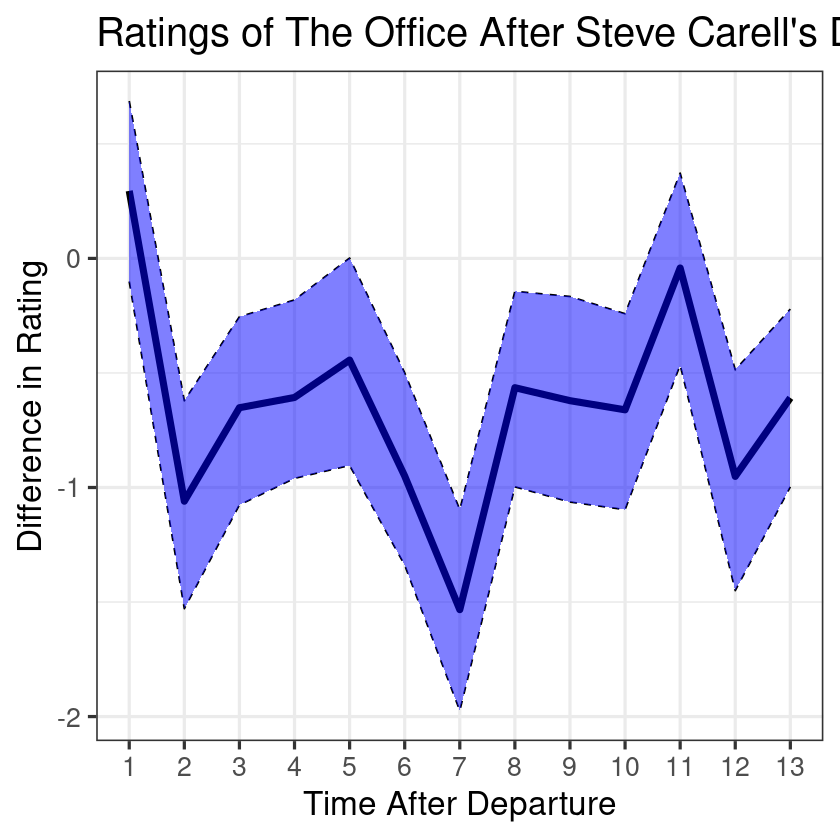

In [135]:
ciExamplePlot

In [136]:
treatErrorTableForLatex


\begin{tabular}{l|l}
\hline
Method & MSE (SE)\\
\hline
MC-NNM & 1.371 (0.003)\\
\hline
Weighted softImpute & 0.616 (0.002)\\
\hline
FACTOR & 0.003 (0)\\
\hline
r1Comp & 0.009 (0)\\
\hline
Weighted R1Comp & 0.004 (0)\\
\hline
\end{tabular}

In [137]:
forecastMSEDataForLatex


\begin{tabular}{l|l}
\hline
Method & MSE (SE)\\
\hline
MC-NNM & 1.348 (0.038)\\
\hline
Weighted softImpute & 1.058 (0.07)\\
\hline
FACTOR & 0.447 (0.043)\\
\hline
r1Comp & 0.534 (0.048)\\
\hline
Weighted R1Comp & 0.507 (0.053)\\
\hline
\end{tabular}

In [138]:
if (!exists("./plotsAndTables")){
    
    dir.create('./plotsAndTables')
    
}

outputDir <- './plotsAndTables'






makeFilename <- function(directory, fileName){
    
    paste(directory, fileName, sep='/')
}

ggsave(makeFilename(outputDir, "ci_example_office.pdf"), ciExamplePlot, width=11, height=8.5)


ggsave(makeFilename(outputDir, "comedy_panel_example.pdf"), panelDataExample , width=11, height=8.5)


ggsave(makeFilename(outputDir, "group_comparison.pdf"), groupComparisonPlot, width=11, height=8.5)

fileConn<-file(makeFilename(outputDir, "effect_estimate_evaluation_ratings.txt"))
writeLines(treatErrorTableForLatex, fileConn)
close(fileConn)

fileConn<-file(makeFilename(outputDir, "forecast_estimate_evaluation_ratings.txt"))
writeLines(forecastMSEDataForLatex, fileConn)
close(fileConn)

fileConn<-file(makeFilename(outputDir, "estimated_ratings_ci_coverage.txt"))
writeLines(confidenceDataFrameLatex, fileConn)
close(fileConn)




Warning message in dir.create("./plotsAndTables"):
“'./plotsAndTables' already exists”
